# 🎯 Binary Classification Project — Predicting Car Color (White vs. Black)
This project aims to develop a binary classification model to predict whether a second-hand car should be repainted white or not (i.e., black), based on its technical and categorical attributes.

The dataset, adapted from a Kaggle car price prediction challenge, includes features such as price, taxes, mileage, manufacturer, engine volume, and more. Only cars originally painted white or black are considered.

Through exploratory analysis, preprocessing, and the use of machine learning algorithms (Decision Tree, Random Forest, and XGBoost), we aim to:

Understand the underlying patterns of the data

Build and fine-tune classification models

Compare model performance and interpret feature importance

# 🔍 1. Exploratory Data Analysis
In this section, we begin by importing the dataset and taking an initial look at its structure and contents. We'll check for missing values, identify potential data quality issues, and get a basic understanding of the feature distributions.

Next, we'll separate the variables into categorical and numerical groups to analyze them accordingly. We'll explore the distribution of each variable, look for anomalies or outliers, and assess whether the features make sense in the context of our goal: predicting whether a car should be repainted white or not.

This initial exploration will help guide our decisions for preprocessing, feature engineering, and model selection in the later stages.

## Import Libraries for EDA


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

## Load Dataset


In [18]:
df = pd.read_excel("datos_tarea25.xlsx")

In [19]:
df.head()

,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,39493,891,HYUNDAI,2016,Jeep,Yes,Diesel,2,160931 km,4,Automatic,Front,Left wheel,White,4
1,1803,761,TOYOTA,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4,Automatic,Front,Left wheel,White,12
2,1098,394,TOYOTA,2014,Sedan,Yes,Hybrid,2.5,398069 km,4,Automatic,Front,Left wheel,Black,12
3,941,1053,MERCEDES-BENZ,2014,Sedan,Yes,Diesel,3.5,184467 km,6,Automatic,Rear,Left wheel,White,12
4,1019,1055,LEXUS,2013,Jeep,Yes,Hybrid,3.5,138038 km,6,Automatic,Front,Left wheel,White,12


## Shape & Missing Values

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             4340 non-null   int64 
 1   Levy              4340 non-null   object
 2   Manufacturer      4340 non-null   object
 3   Prod. year        4340 non-null   int64 
 4   Category          4340 non-null   object
 5   Leather interior  4340 non-null   object
 6   Fuel type         4340 non-null   object
 7   Engine volume     4340 non-null   object
 8   Mileage           4340 non-null   object
 9   Cylinders         4340 non-null   int64 
 10  Gear box type     4340 non-null   object
 11  Drive wheels      4340 non-null   object
 12  Wheel             4340 non-null   object
 13  Color             4340 non-null   object
 14  Airbags           4340 non-null   int64 
dtypes: int64(4), object(11)
memory usage: 508.7+ KB


There are in total 15 columns (variables), and 4340 instances with no missing values.

## Check and Removal from Duplicates

Checking for duplicate is important because repeated entries can bias the model, causing it to favor certain patterns or classes that appear more frequently; not because they are more relevant, but because they are duplicated. 

Removing these helps improve the fairness and generalization of the model.

In [21]:
df.duplicated().sum()

1534

In [22]:
df.duplicated(subset=df.columns.difference(["Color"])).sum()

1534

There are a total of 1534 duplicates on this dataset, this is around **35%**. By deleting them, we still have around **65%** of raw useful data.

In [23]:
df = df.drop_duplicates()

## Check Unique Value

Before separating and analyzing categorical and numerical variables, it's important to check the number of unique values in each column. This helps ensure that:

No categorical variable is mistakenly stored as numerical (e.g., binary variables stored as 0/1 or encoded labels).

No numerical variable has too few unique values, in which case it might be more meaningful to treat it as categorical.

This step ensures that each variable is correctly classified before proceeding with EDA or modeling.

In [24]:
df.nunique()

Price                915
Levy                 203
Manufacturer           4
Prod. year            29
Category               3
Leather interior       2
Fuel type              3
Engine volume         58
Mileage             1826
Cylinders             10
Gear box type          2
Drive wheels           3
Wheel                  2
Color                  2
Airbags               16
dtype: int64

`Prod. year` and `Airbags` are set as numerical, but changing them to categorical would be better for the modelling.

In [25]:
df["Prod. year"] = df["Prod. year"].astype(str)
df["Airbags"] = df["Airbags"].astype(str)
df["Cylinders"] = df["Cylinders"].astype(str)

- There are 1826 unique values for the `Mileage` variable, which is about **65%** of the total dataset size. It's more appropiate to treat it as a numerical variable.

- The `Levy` column contains 203 unique values, representing around 7% of the total dataset. This variable indicates the tax amount paid per car sale. Since its values are spread across a wide, non-categorical range, it exhibits continuous behavior, and converting it to a numerical variable is a logical choice.

In [26]:
# Milage categoriical to numerical
df["Mileage"] = df["Mileage"].str.split().str[0]
df["Mileage"] = df["Mileage"].astype(int)

df["Levy"] = pd.to_numeric(df["Levy"], errors = "coerce")
df["Levy"] = df["Levy"].fillna(df["Levy"].mean())

## 🧮 Categorical Variables
We begin by exploring the categorical variables in the dataset. The goal is to understand their structure, relevance, and how to best prepare them for machine learning models. Specifically, we will:

- Count the number of unique values per categorical column

- Identify whether variables are binary (dichotomous) or multiclass

- Decide if any categorical variables should be transformed into numerical form (e.g., label encoding, one-hot encoding)

- Check for class imbalance or dominant categories that might affect the model

- Assess whether some categorical features carry useful information or should be dropped due to low variability or redundancy

### Unique Values and Frequency

In [27]:
df.describe(include = ['O'])

,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
count,2806,2806,2806,2806,2806,2806,2806,2806,2806,2806,2806,2806
unique,4,29,3,2,3,58,10,2,3,2,2,16
top,HYUNDAI,2012,Sedan,Yes,Petrol,2,4,Automatic,Front,Left wheel,Black,12
freq,1038,392,1478,2259,1558,558,2102,2168,2010,2710,1438,1026


### Distribution Plot & Class Imbalances

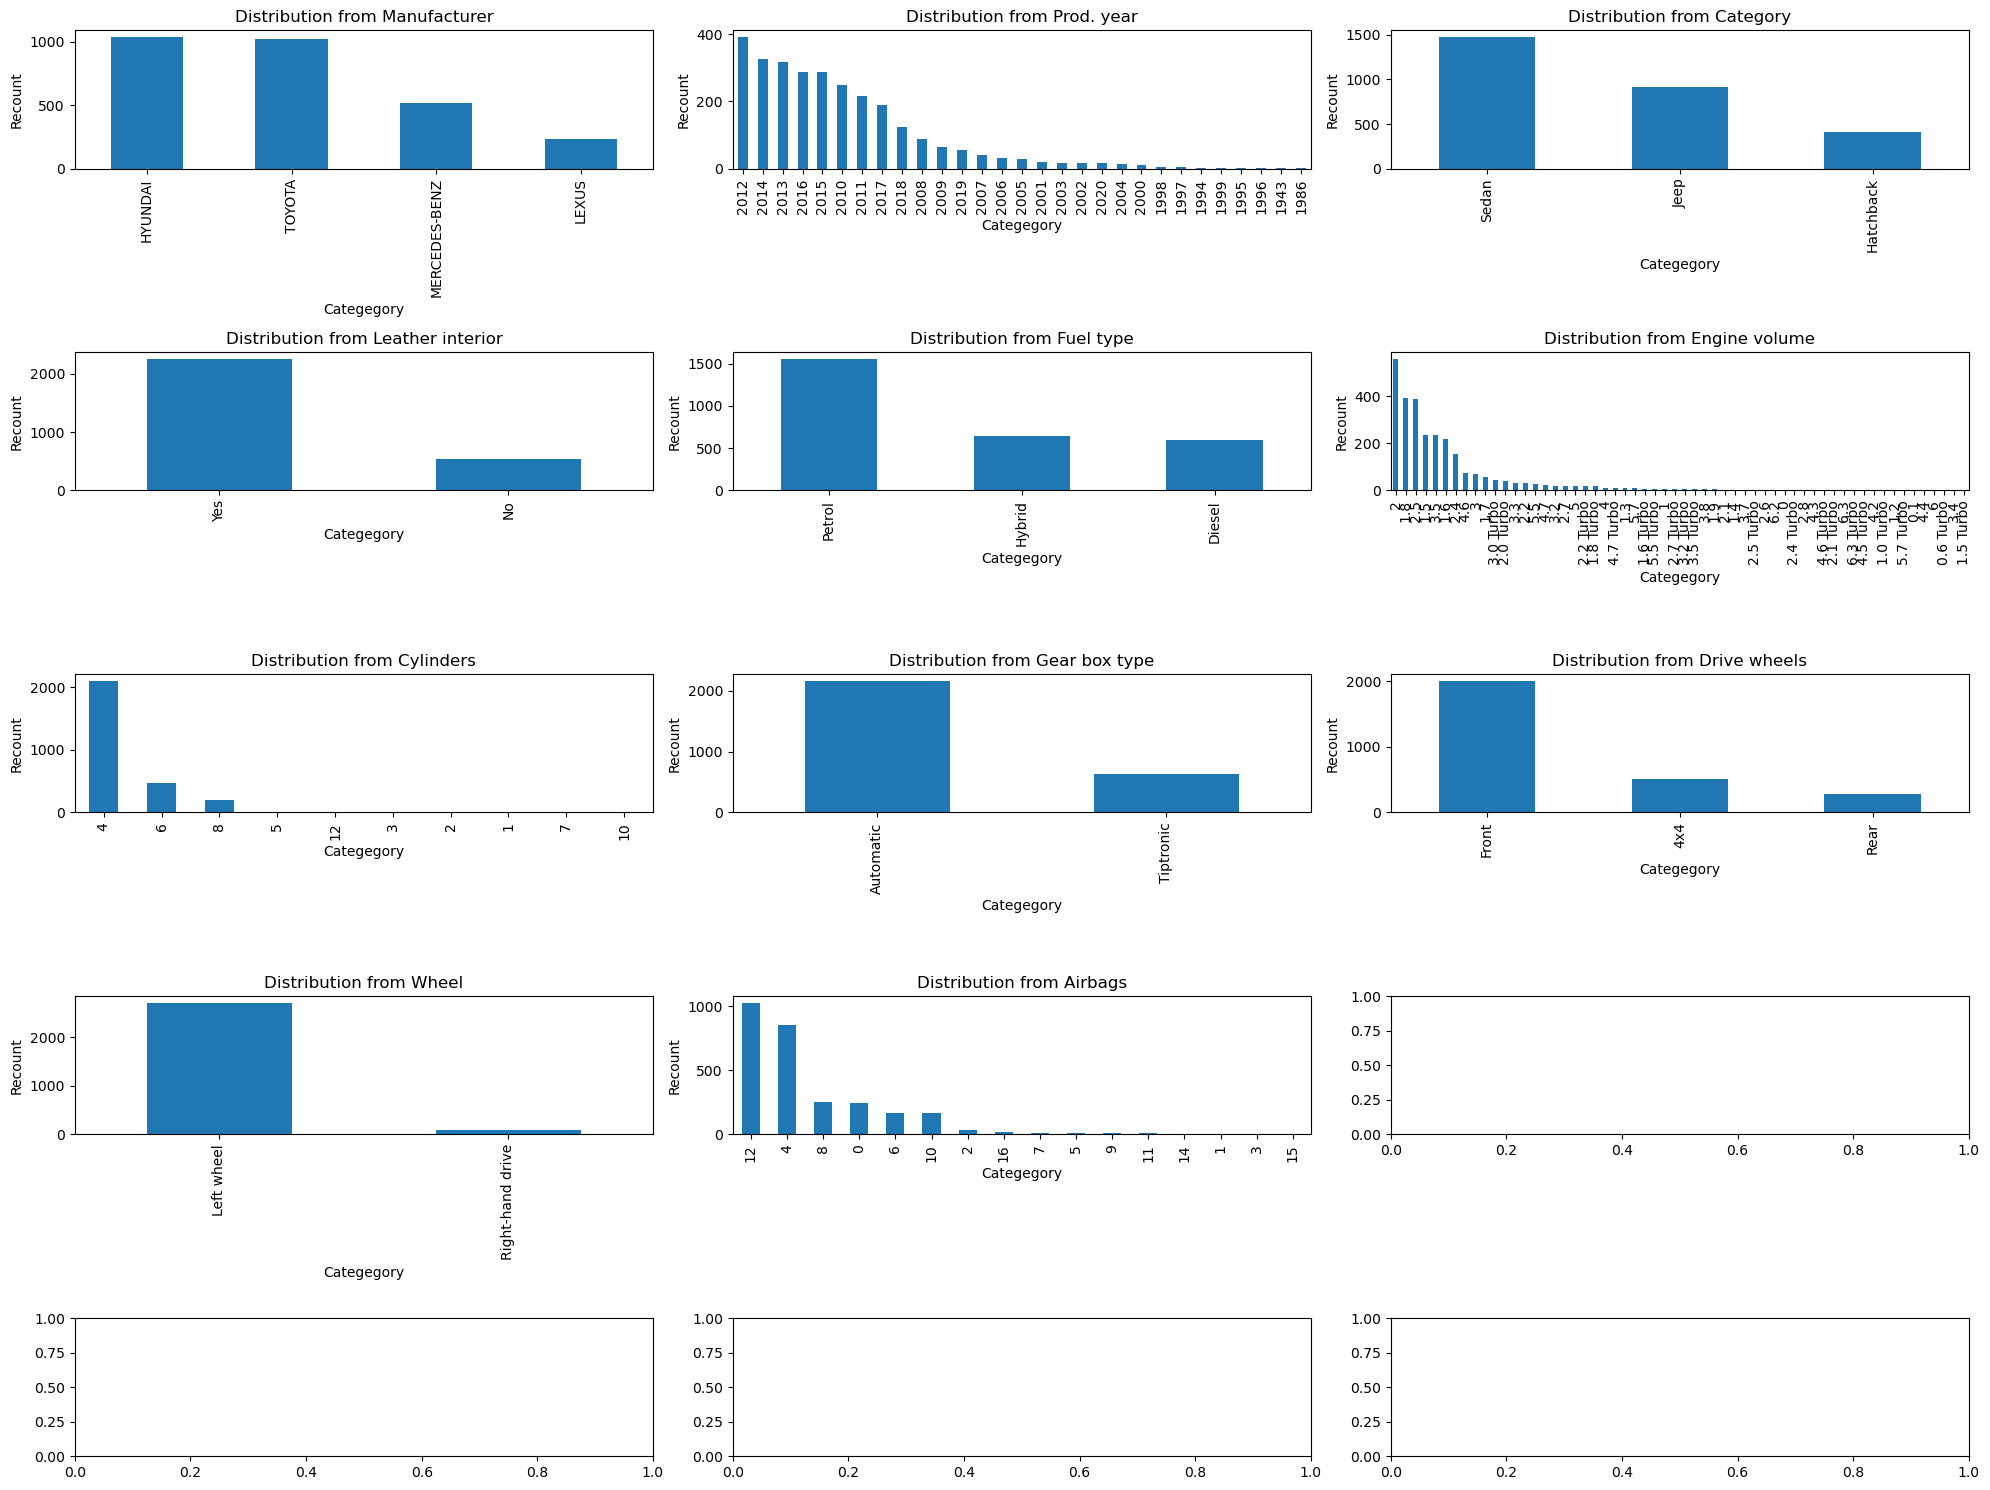

In [ ]:
categorical = [col for col in df.columns if df[col].dtype == "O"]
categorical.remove("Color")
fig, axes = plt.subplots(4, 3, figsize=(20, 15))  # Adjust figure size
for i, col in enumerate(categorical):
	row, col_idx = divmod(i ,3)
	df[col].value_counts().plot(kind='bar', ax = axes[row, col_idx])
	axes[row, col_idx].set_title(f"Distribution from {col}")
	axes[row, col_idx].set_xlabel("Categegory")
	axes[row, col_idx].set_ylabel("Recount")

plt.tight_layout()
plt.show()

Some imbalance was detected in the following variables:

- `Leather Interior`: Over 2,000 entries are labeled as "Yes", while only a little over 500 are labeled "No". This imbalance may affect model performance and should be monitored.

- `Wheel`: The majority of entries (~2,500) correspond to "Left-hand drive", while "Right-hand drive" appears in fewer than 250 instances. This significant imbalance could influence how the model interprets the feature.
  
- `Gear box type`: Over 2,000 entries are labeled as "Automatic", while only a little over 500 are labeled "Triptonic". This imbalance may affect model performance and should be monitored.


The remaining categorical variables appear to be relatively well balanced and do not raise immediate concerns.

### Cross-Tabulation

In [29]:
result = []
for col in categorical:
	cross_table = pd.crosstab(df["Color"], df[col])
	chi2, p, dof, expected = chi2_contingency(cross_table)
	result.append({
		"Variable": col,
		"Chi2": chi2,
		"p": p,
		"Significant p < 0.05": p < 0.05
	})
chi2_df = pd.DataFrame(result).sort_values(by="Chi2", ascending=False)
chi2_df

,Variable,Chi2,p,Significant p < 0.05
5,Engine volume,315.380820,1.903190e-37,True
10,Airbags,131.022575,1.340699e-20,True
0,Manufacturer,115.535601,7.059475e-25,True
6,Cylinders,95.921627,1.048377e-16,True
8,Drive wheels,87.453856,1.022437e-19,True
7,Gear box type,75.678256,3.338639e-18,True
4,Fuel type,75.502907,4.024872e-17,True
1,Prod. year,73.702969,5.564109e-06,True
2,Category,61.144463,5.280179e-14,True
3,Leather interior,10.397660,1.261751e-03,True


### Categorical EDA Conclusion
- `Engine volume` contains many distinct values. However, these values fall within a logical range, so no transformation is needed. It shows a high concentration aroun 2.0L, it has a high Chi2 and p-value is below 0.05. 

- `Leather Interior`, `Gear box type`, and `Wheel`  are binary and can be transformed into 0/1 to simplify downstream processing. Despite their lower Chi2 values, which were expected for binary variables, they still have a p-value below 0.05.

- Lastly, the variables `Fuel Type`, `Manufacturer`, `Category` and `Drive Wheels` present a high CHi2 as well as a strong p-value.


<h2 style ="color:red">
falta por incluir airbagas y prod_year en conclusion

</h2>


All analyzed categorical variables demonstrate a statistically significant association with the target variable `Color`. Therefore, we will retain all of them for further processing.


Also, the target variable `Color` is binary. It will be also transformed into 0/1.

## Numerical Variables



### Temporary Transformation from Variables

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2806.0,23913.585531,2.602872e+04,3.0,9408.00,18821.5,31361.0,6.272200e+05
Levy,2806.0,900.429558,4.448784e+02,87.0,707.00,891.0,930.0,1.171400e+04
Mileage,2806.0,521706.571632,2.097346e+07,0.0,62920.75,113600.0,165166.5,1.111111e+09
Leather interior num,2806.0,0.805061,3.962247e-01,0.0,1.00,1.0,1.0,1.000000e+00
Gear box type num,2806.0,0.772630,4.192081e-01,0.0,1.00,1.0,1.0,1.000000e+00
Wheel num,2806.0,0.965788,1.818067e-01,0.0,1.00,1.0,1.0,1.000000e+00
Color num,2806.0,0.487527,4.999335e-01,0.0,0.00,0.0,1.0,1.000000e+00


# 2. Data Cleaning and Preprocessing

### Transformation of `Leather Interior`, `Gear box type`, `Wheel` and `Color` Variables in Dicotomic

In [36]:
# df["Leather interior"] = df["Leather interior"].map({"Yes": 1, "No": 0})
# df["Gear box type"] = df["Gear box type"].map({"Automatic": 0, "Tiptronic": 1})
# df["Color"] = df["Color"].map({"Black": 0, "White": 1})

# 3. Modeling: Decision Tree

# 4. Modeling: Random Forest & XGBoost

# 5. Evaluation and Comparison